Charging strategy: GENERATION
Strategy status:   ACTIVE

DEBUG – Netzbezug-Auswertung
Anzahl Debug-Zeilen insgesamt: 7924
Anzahl Debug-Zeilen mit Netzbezug: 5622
Anzahl Zeitschritte mit Netzbezug: 175


ts
2025-12-03 07:15:00    550.000000
2025-12-11 08:45:00    536.840417
2025-12-01 08:45:00    532.937328
2025-12-09 09:45:00    531.958675
2025-12-01 08:00:00    531.868156
2025-12-12 09:00:00    528.819990
2025-12-01 09:30:00    528.300507
2025-12-12 10:45:00    528.040678
2025-12-12 08:45:00    525.705803
2025-12-10 08:30:00    522.021819
Name: grid_import_kw, dtype: float64


=== Netzbezug-Zeitschritt: 2025-12-03 07:15:00 ===


,ts,vehicle_name,arrival_time,departure_time,parking_hours,slack_minutes,is_emergency,pv_kw,base_kw,pv_surplus_kw,site_total_power_kw,grid_import_kw,has_any_emergency_this_step
1704,2025-12-03 07:15:00,EQE SUV,2025-12-03 06:01:29.741252,2025-12-03 09:25:54.499333,3.406877,58.122573,True,200.0,100.0,100.0,650.0,550.0,True
1724,2025-12-03 07:15:00,EQE SUV,2025-12-03 06:01:29.741252,2025-12-03 09:25:54.499333,3.406877,58.122573,True,200.0,100.0,100.0,650.0,550.0,True
1705,2025-12-03 07:15:00,ID.4 Pro 4Motion,2025-12-03 07:06:17.091460,2025-12-03 10:28:02.447441,3.362599,114.829968,False,200.0,100.0,100.0,650.0,550.0,True
1725,2025-12-03 07:15:00,ID.4 Pro 4Motion,2025-12-03 07:06:17.091460,2025-12-03 10:28:02.447441,3.362599,114.829968,False,200.0,100.0,100.0,650.0,550.0,True
1706,2025-12-03 07:15:00,i4 xDrive40,2025-12-03 07:11:03.872236,2025-12-03 10:54:33.176036,3.724807,208.502303,False,200.0,100.0,100.0,650.0,550.0,True
1726,2025-12-03 07:15:00,i4 xDrive40,2025-12-03 07:11:03.872236,2025-12-03 10:54:33.176036,3.724807,208.502303,False,200.0,100.0,100.0,650.0,550.0,True
1707,2025-12-03 07:15:00,600e,2025-12-03 07:06:12.852905,2025-12-03 11:04:18.336746,3.968190,211.627128,False,200.0,100.0,100.0,650.0,550.0,True
1727,2025-12-03 07:15:00,600e,2025-12-03 07:06:12.852905,2025-12-03 11:04:18.336746,3.968190,211.627128,False,200.0,100.0,100.0,650.0,550.0,True
1708,2025-12-03 07:15:00,2 LR SM,2025-12-03 06:19:56.983146,2025-12-03 11:09:13.995267,4.821392,212.064233,False,200.0,100.0,100.0,650.0,550.0,True
1728,2025-12-03 07:15:00,2 LR SM,2025-12-03 06:19:56.983146,2025-12-03 11:09:13.995267,4.821392,212.064233,False,200.0,100.0,100.0,650.0,550.0,True



=== Netzbezug-Zeitschritt: 2025-12-11 08:45:00 ===


,ts,vehicle_name,arrival_time,departure_time,parking_hours,slack_minutes,is_emergency,pv_kw,base_kw,pv_surplus_kw,site_total_power_kw,grid_import_kw,has_any_emergency_this_step
6360,2025-12-11 08:45:00,Air Grand Touring,2025-12-11 07:33:17.257855,2025-12-11 09:13:13.377483,1.665589,-41.876995,True,200.0,100.0,100.0,636.840417,536.840417,True
6380,2025-12-11 08:45:00,Air Grand Touring,2025-12-11 07:33:17.257855,2025-12-11 09:13:13.377483,1.665589,-41.876995,True,200.0,100.0,100.0,636.840417,536.840417,True
6361,2025-12-11 08:45:00,G80 Electrified,2025-12-11 07:57:53.760120,2025-12-11 08:45:49.166794,0.798724,-7.802551,True,200.0,100.0,100.0,636.840417,536.840417,True
6381,2025-12-11 08:45:00,G80 Electrified,2025-12-11 07:57:53.760120,2025-12-11 08:45:49.166794,0.798724,-7.802551,True,200.0,100.0,100.0,636.840417,536.840417,True
6362,2025-12-11 08:45:00,IONIQ 5,2025-12-11 08:00:19.735549,2025-12-11 09:24:15.379222,1.398790,18.933784,True,200.0,100.0,100.0,636.840417,536.840417,True
6382,2025-12-11 08:45:00,IONIQ 5,2025-12-11 08:00:19.735549,2025-12-11 09:24:15.379222,1.398790,18.933784,True,200.0,100.0,100.0,636.840417,536.840417,True
6363,2025-12-11 08:45:00,Niro EV,2025-12-11 08:17:10.124923,2025-12-11 09:20:34.052325,1.056647,20.297523,True,200.0,100.0,100.0,636.840417,536.840417,True
6383,2025-12-11 08:45:00,Niro EV,2025-12-11 08:17:10.124923,2025-12-11 09:20:34.052325,1.056647,20.297523,True,200.0,100.0,100.0,636.840417,536.840417,True
6364,2025-12-11 08:45:00,Model Y,2025-12-11 08:34:51.811396,2025-12-11 10:03:44.914038,1.481417,24.076414,True,200.0,100.0,100.0,636.840417,536.840417,True
6384,2025-12-11 08:45:00,Model Y,2025-12-11 08:34:51.811396,2025-12-11 10:03:44.914038,1.481417,24.076414,True,200.0,100.0,100.0,636.840417,536.840417,True



=== Netzbezug-Zeitschritt: 2025-12-01 08:45:00 ===


,ts,vehicle_name,arrival_time,departure_time,parking_hours,slack_minutes,is_emergency,pv_kw,base_kw,pv_surplus_kw,site_total_power_kw,grid_import_kw,has_any_emergency_this_step
164,2025-12-01 08:45:00,Taycan Tourismo,2025-12-01 07:45:48.250790,2025-12-01 08:47:16.452223,1.024500,-36.549831,True,200.0,100.0,100.0,632.937328,532.937328,True
184,2025-12-01 08:45:00,Taycan Tourismo,2025-12-01 07:45:48.250790,2025-12-01 08:47:16.452223,1.024500,-36.549831,True,200.0,100.0,100.0,632.937328,532.937328,True
165,2025-12-01 08:45:00,i7 xDrive60,2025-12-01 08:10:45.165206,2025-12-01 08:50:40.855242,0.665469,-2.143425,True,200.0,100.0,100.0,632.937328,532.937328,True
185,2025-12-01 08:45:00,i7 xDrive60,2025-12-01 08:10:45.165206,2025-12-01 08:50:40.855242,0.665469,-2.143425,True,200.0,100.0,100.0,632.937328,532.937328,True
166,2025-12-01 08:45:00,Niro EV,2025-12-01 08:07:40.488135,2025-12-01 09:01:47.694111,0.902002,5.736449,True,200.0,100.0,100.0,632.937328,532.937328,True
186,2025-12-01 08:45:00,Niro EV,2025-12-01 08:07:40.488135,2025-12-01 09:01:47.694111,0.902002,5.736449,True,200.0,100.0,100.0,632.937328,532.937328,True
167,2025-12-01 08:45:00,G80 Electrified,2025-12-01 08:16:38.566500,2025-12-01 09:02:47.522987,0.769155,6.669439,True,200.0,100.0,100.0,632.937328,532.937328,True
187,2025-12-01 08:45:00,G80 Electrified,2025-12-01 08:16:38.566500,2025-12-01 09:02:47.522987,0.769155,6.669439,True,200.0,100.0,100.0,632.937328,532.937328,True
168,2025-12-01 08:45:00,i7 xDrive60,2025-12-01 08:38:26.671991,2025-12-01 09:41:09.202398,1.045147,35.540466,True,200.0,100.0,100.0,632.937328,532.937328,True
188,2025-12-01 08:45:00,i7 xDrive60,2025-12-01 08:38:26.671991,2025-12-01 09:41:09.202398,1.045147,35.540466,True,200.0,100.0,100.0,632.937328,532.937328,True



=== Netzbezug-Zeitschritt: 2025-12-09 09:45:00 ===


,ts,vehicle_name,arrival_time,departure_time,parking_hours,slack_minutes,is_emergency,pv_kw,base_kw,pv_surplus_kw,site_total_power_kw,grid_import_kw,has_any_emergency_this_step
5062,2025-12-09 09:45:00,iX xDrive50,2025-12-09 08:36:22.638288,2025-12-09 09:54:39.590785,1.304709,-26.087950,True,200.0,100.0,100.0,631.958675,531.958675,True
5082,2025-12-09 09:45:00,iX xDrive50,2025-12-09 08:36:22.638288,2025-12-09 09:54:39.590785,1.304709,-26.087950,True,200.0,100.0,100.0,631.958675,531.958675,True
5063,2025-12-09 09:45:00,Model S,2025-12-09 08:10:38.704662,2025-12-09 10:33:58.523803,2.388839,24.322224,True,200.0,100.0,100.0,631.958675,531.958675,True
5083,2025-12-09 09:45:00,Model S,2025-12-09 08:10:38.704662,2025-12-09 10:33:58.523803,2.388839,24.322224,True,200.0,100.0,100.0,631.958675,531.958675,True
5064,2025-12-09 09:45:00,EQE,2025-12-09 09:04:05.917028,2025-12-09 10:19:06.294641,1.250105,24.921544,True,200.0,100.0,100.0,631.958675,531.958675,True
5084,2025-12-09 09:45:00,EQE,2025-12-09 09:04:05.917028,2025-12-09 10:19:06.294641,1.250105,24.921544,True,200.0,100.0,100.0,631.958675,531.958675,True
5065,2025-12-09 09:45:00,CLA,2025-12-09 09:26:03.720969,2025-12-09 10:38:47.345830,1.212118,44.444331,True,200.0,100.0,100.0,631.958675,531.958675,True
5085,2025-12-09 09:45:00,CLA,2025-12-09 09:26:03.720969,2025-12-09 10:38:47.345830,1.212118,44.444331,True,200.0,100.0,100.0,631.958675,531.958675,True
5066,2025-12-09 09:45:00,XC40 Recharge,2025-12-09 08:20:49.758168,2025-12-09 10:44:08.229219,2.388464,49.112855,True,200.0,100.0,100.0,631.958675,531.958675,True
5086,2025-12-09 09:45:00,XC40 Recharge,2025-12-09 08:20:49.758168,2025-12-09 10:44:08.229219,2.388464,49.112855,True,200.0,100.0,100.0,631.958675,531.958675,True



=== Netzbezug-Zeitschritt: 2025-12-01 08:00:00 ===


,ts,vehicle_name,arrival_time,departure_time,parking_hours,slack_minutes,is_emergency,pv_kw,base_kw,pv_surplus_kw,site_total_power_kw,grid_import_kw,has_any_emergency_this_step
44,2025-12-01 08:00:00,Taycan Tourismo,2025-12-01 07:45:48.250790,2025-12-01 08:47:16.452223,1.024500,-20.799831,True,200.0,100.0,100.0,631.868156,531.868156,True
64,2025-12-01 08:00:00,Taycan Tourismo,2025-12-01 07:45:48.250790,2025-12-01 08:47:16.452223,1.024500,-20.799831,True,200.0,100.0,100.0,631.868156,531.868156,True
45,2025-12-01 08:00:00,ID.7,2025-12-01 07:56:43.774196,2025-12-01 08:35:46.032680,0.650627,22.035202,True,200.0,100.0,100.0,631.868156,531.868156,True
65,2025-12-01 08:00:00,ID.7,2025-12-01 07:56:43.774196,2025-12-01 08:35:46.032680,0.650627,22.035202,True,200.0,100.0,100.0,631.868156,531.868156,True
46,2025-12-01 08:00:00,Model S,2025-12-01 07:38:31.993475,2025-12-01 08:42:13.092670,1.061416,27.372773,True,200.0,100.0,100.0,631.868156,531.868156,True
66,2025-12-01 08:00:00,Model S,2025-12-01 07:38:31.993475,2025-12-01 08:42:13.092670,1.061416,27.372773,True,200.0,100.0,100.0,631.868156,531.868156,True
47,2025-12-01 08:00:00,ID.7 Tourer,2025-12-01 07:52:29.907392,2025-12-01 10:18:29.400645,2.433193,81.138167,False,200.0,100.0,100.0,631.868156,531.868156,True
67,2025-12-01 08:00:00,ID.7 Tourer,2025-12-01 07:52:29.907392,2025-12-01 10:18:29.400645,2.433193,81.138167,False,200.0,100.0,100.0,631.868156,531.868156,True
48,2025-12-01 08:00:00,ID.3,2025-12-01 07:34:41.688985,2025-12-01 09:55:54.270818,2.353495,87.579097,False,200.0,100.0,100.0,631.868156,531.868156,True
68,2025-12-01 08:00:00,ID.3,2025-12-01 07:34:41.688985,2025-12-01 09:55:54.270818,2.353495,87.579097,False,200.0,100.0,100.0,631.868156,531.868156,True



=== Netzbezug-Zeitschritt: 2025-12-12 09:00:00 ===


,ts,vehicle_name,arrival_time,departure_time,parking_hours,slack_minutes,is_emergency,pv_kw,base_kw,pv_surplus_kw,site_total_power_kw,grid_import_kw,has_any_emergency_this_step
7052,2025-12-12 09:00:00,Niro EV,2025-12-12 08:43:39.497937,2025-12-12 09:26:21.954565,0.711794,-25.992072,True,200.0,100.0,100.0,628.81999,528.81999,True
7072,2025-12-12 09:00:00,Niro EV,2025-12-12 08:43:39.497937,2025-12-12 09:26:21.954565,0.711794,-25.992072,True,200.0,100.0,100.0,628.81999,528.81999,True
7053,2025-12-12 09:00:00,e-tron GT,2025-12-12 08:30:41.182664,2025-12-12 09:30:25.546285,0.995657,-18.183737,True,200.0,100.0,100.0,628.81999,528.81999,True
7073,2025-12-12 09:00:00,e-tron GT,2025-12-12 08:30:41.182664,2025-12-12 09:30:25.546285,0.995657,-18.183737,True,200.0,100.0,100.0,628.81999,528.81999,True
7054,2025-12-12 09:00:00,EV60,2025-12-12 08:29:18.246767,2025-12-12 10:13:03.610775,1.729268,67.692592,False,200.0,100.0,100.0,628.81999,528.81999,True
7074,2025-12-12 09:00:00,EV60,2025-12-12 08:29:18.246767,2025-12-12 10:13:03.610775,1.729268,67.692592,False,200.0,100.0,100.0,628.81999,528.81999,True
7055,2025-12-12 09:00:00,Model X,2025-12-12 08:17:40.492751,2025-12-12 10:47:44.593445,2.501139,70.988082,False,200.0,100.0,100.0,628.81999,528.81999,True
7075,2025-12-12 09:00:00,Model X,2025-12-12 08:17:40.492751,2025-12-12 10:47:44.593445,2.501139,70.988082,False,200.0,100.0,100.0,628.81999,528.81999,True
7056,2025-12-12 09:00:00,Taycan Tourismo,2025-12-12 08:42:57.139812,2025-12-12 11:04:58.021711,2.366912,88.409178,False,200.0,100.0,100.0,628.81999,528.81999,True
7076,2025-12-12 09:00:00,Taycan Tourismo,2025-12-12 08:42:57.139812,2025-12-12 11:04:58.021711,2.366912,88.409178,False,200.0,100.0,100.0,628.81999,528.81999,True



=== Netzbezug-Zeitschritt: 2025-12-01 09:30:00 ===


,ts,vehicle_name,arrival_time,departure_time,parking_hours,slack_minutes,is_emergency,pv_kw,base_kw,pv_surplus_kw,site_total_power_kw,grid_import_kw,has_any_emergency_this_step
284,2025-12-01 09:30:00,2 LR SM,2025-12-01 09:06:46.766965,2025-12-01 09:57:41.190796,0.848451,-9.866926,True,200.0,100.0,100.0,628.300507,528.300507,True
304,2025-12-01 09:30:00,2 LR SM,2025-12-01 09:06:46.766965,2025-12-01 09:57:41.190796,0.848451,-9.866926,True,200.0,100.0,100.0,628.300507,528.300507,True
285,2025-12-01 09:30:00,Astra Electric GS,2025-12-01 09:09:05.932634,2025-12-01 09:46:26.890593,0.622488,0.322770,True,200.0,100.0,100.0,628.300507,528.300507,True
305,2025-12-01 09:30:00,Astra Electric GS,2025-12-01 09:09:05.932634,2025-12-01 09:46:26.890593,0.622488,0.322770,True,200.0,100.0,100.0,628.300507,528.300507,True
286,2025-12-01 09:30:00,EQC,2025-12-01 08:21:52.909455,2025-12-01 10:09:54.381478,1.800409,34.880414,True,200.0,100.0,100.0,628.300507,528.300507,True
306,2025-12-01 09:30:00,EQC,2025-12-01 08:21:52.909455,2025-12-01 10:09:54.381478,1.800409,34.880414,True,200.0,100.0,100.0,628.300507,528.300507,True
287,2025-12-01 09:30:00,Model S,2025-12-01 08:24:40.945594,2025-12-01 11:30:17.995514,3.093625,106.372868,False,200.0,100.0,100.0,628.300507,528.300507,True
307,2025-12-01 09:30:00,Model S,2025-12-01 08:24:40.945594,2025-12-01 11:30:17.995514,3.093625,106.372868,False,200.0,100.0,100.0,628.300507,528.300507,True
288,2025-12-01 09:30:00,EQA,2025-12-01 08:30:24.577165,2025-12-01 11:50:29.773589,3.334777,123.584645,False,200.0,100.0,100.0,628.300507,528.300507,True
308,2025-12-01 09:30:00,EQA,2025-12-01 08:30:24.577165,2025-12-01 11:50:29.773589,3.334777,123.584645,False,200.0,100.0,100.0,628.300507,528.300507,True



=== Netzbezug-Zeitschritt: 2025-12-12 10:45:00 ===


,ts,vehicle_name,arrival_time,departure_time,parking_hours,slack_minutes,is_emergency,pv_kw,base_kw,pv_surplus_kw,site_total_power_kw,grid_import_kw,has_any_emergency_this_step
7332,2025-12-12 10:45:00,ID.7,2025-12-12 10:09:46.165708,2025-12-12 10:48:05.126692,0.638600,-25.049965,True,250.0,100.0,150.0,678.040678,528.040678,True
7352,2025-12-12 10:45:00,ID.7,2025-12-12 10:09:46.165708,2025-12-12 10:48:05.126692,0.638600,-25.049965,True,250.0,100.0,150.0,678.040678,528.040678,True
7333,2025-12-12 10:45:00,EQS,2025-12-12 10:32:13.980691,2025-12-12 11:08:18.650555,0.601297,-16.329357,True,250.0,100.0,150.0,678.040678,528.040678,True
7353,2025-12-12 10:45:00,EQS,2025-12-12 10:32:13.980691,2025-12-12 11:08:18.650555,0.601297,-16.329357,True,250.0,100.0,150.0,678.040678,528.040678,True
7334,2025-12-12 10:45:00,EQE SUV,2025-12-12 10:09:16.334162,2025-12-12 10:51:58.522610,0.711719,-6.542678,True,250.0,100.0,150.0,678.040678,528.040678,True
7354,2025-12-12 10:45:00,EQE SUV,2025-12-12 10:09:16.334162,2025-12-12 10:51:58.522610,0.711719,-6.542678,True,250.0,100.0,150.0,678.040678,528.040678,True
7335,2025-12-12 10:45:00,Model X,2025-12-12 10:25:48.638454,2025-12-12 11:07:48.150422,0.699864,-0.959719,True,250.0,100.0,150.0,678.040678,528.040678,True
7355,2025-12-12 10:45:00,Model X,2025-12-12 10:25:48.638454,2025-12-12 11:07:48.150422,0.699864,-0.959719,True,250.0,100.0,150.0,678.040678,528.040678,True
7336,2025-12-12 10:45:00,ID.4 Pro 4Motion,2025-12-12 10:18:13.238779,2025-12-12 11:04:53.302107,0.777795,13.429057,True,250.0,100.0,150.0,678.040678,528.040678,True
7356,2025-12-12 10:45:00,ID.4 Pro 4Motion,2025-12-12 10:18:13.238779,2025-12-12 11:04:53.302107,0.777795,13.429057,True,250.0,100.0,150.0,678.040678,528.040678,True



=== Netzbezug-Zeitschritt: 2025-12-12 08:45:00 ===


,ts,vehicle_name,arrival_time,departure_time,parking_hours,slack_minutes,is_emergency,pv_kw,base_kw,pv_surplus_kw,site_total_power_kw,grid_import_kw,has_any_emergency_this_step
7012,2025-12-12 08:45:00,Niro EV,2025-12-12 08:43:39.497937,2025-12-12 09:26:21.954565,0.711794,-20.742072,True,200.0,100.0,100.0,625.705803,525.705803,True
7032,2025-12-12 08:45:00,Niro EV,2025-12-12 08:43:39.497937,2025-12-12 09:26:21.954565,0.711794,-20.742072,True,200.0,100.0,100.0,625.705803,525.705803,True
7013,2025-12-12 08:45:00,e-tron GT,2025-12-12 08:30:41.182664,2025-12-12 09:30:25.546285,0.995657,-12.933737,True,200.0,100.0,100.0,625.705803,525.705803,True
7033,2025-12-12 08:45:00,e-tron GT,2025-12-12 08:30:41.182664,2025-12-12 09:30:25.546285,0.995657,-12.933737,True,200.0,100.0,100.0,625.705803,525.705803,True
7014,2025-12-12 08:45:00,EV60,2025-12-12 08:29:18.246767,2025-12-12 10:13:03.610775,1.729268,72.942592,False,200.0,100.0,100.0,625.705803,525.705803,True
7034,2025-12-12 08:45:00,EV60,2025-12-12 08:29:18.246767,2025-12-12 10:13:03.610775,1.729268,72.942592,False,200.0,100.0,100.0,625.705803,525.705803,True
7015,2025-12-12 08:45:00,Model X,2025-12-12 08:17:40.492751,2025-12-12 10:47:44.593445,2.501139,76.238082,False,200.0,100.0,100.0,625.705803,525.705803,True
7035,2025-12-12 08:45:00,Model X,2025-12-12 08:17:40.492751,2025-12-12 10:47:44.593445,2.501139,76.238082,False,200.0,100.0,100.0,625.705803,525.705803,True
7016,2025-12-12 08:45:00,Taycan Tourismo,2025-12-12 08:42:57.139812,2025-12-12 11:04:58.021711,2.366912,93.659178,False,200.0,100.0,100.0,625.705803,525.705803,True
7036,2025-12-12 08:45:00,Taycan Tourismo,2025-12-12 08:42:57.139812,2025-12-12 11:04:58.021711,2.366912,93.659178,False,200.0,100.0,100.0,625.705803,525.705803,True



=== Netzbezug-Zeitschritt: 2025-12-10 08:30:00 ===


,ts,vehicle_name,arrival_time,departure_time,parking_hours,slack_minutes,is_emergency,pv_kw,base_kw,pv_surplus_kw,site_total_power_kw,grid_import_kw,has_any_emergency_this_step
5500,2025-12-10 08:30:00,EQS,2025-12-10 08:16:36.292894,2025-12-10 09:43:01.869153,1.440438,17.940224,True,200.0,100.0,100.0,622.021819,522.021819,True
5520,2025-12-10 08:30:00,EQS,2025-12-10 08:16:36.292894,2025-12-10 09:43:01.869153,1.440438,17.940224,True,200.0,100.0,100.0,622.021819,522.021819,True
5501,2025-12-10 08:30:00,EV60,2025-12-10 07:56:15.846419,2025-12-10 09:41:08.314850,1.747908,57.152739,True,200.0,100.0,100.0,622.021819,522.021819,True
5521,2025-12-10 08:30:00,EV60,2025-12-10 07:56:15.846419,2025-12-10 09:41:08.314850,1.747908,57.152739,True,200.0,100.0,100.0,622.021819,522.021819,True
5502,2025-12-10 08:30:00,Model 3,2025-12-10 08:23:15.115593,2025-12-10 09:37:30.565595,1.237625,58.775145,True,200.0,100.0,100.0,622.021819,522.021819,True
5522,2025-12-10 08:30:00,Model 3,2025-12-10 08:23:15.115593,2025-12-10 09:37:30.565595,1.237625,58.775145,True,200.0,100.0,100.0,622.021819,522.021819,True
5503,2025-12-10 08:30:00,i4 xDrive40,2025-12-10 08:25:07.577135,2025-12-10 11:04:07.354543,2.649938,108.355965,False,200.0,100.0,100.0,622.021819,522.021819,True
5523,2025-12-10 08:30:00,i4 xDrive40,2025-12-10 08:25:07.577135,2025-12-10 11:04:07.354543,2.649938,108.355965,False,200.0,100.0,100.0,622.021819,522.021819,True
5504,2025-12-10 08:30:00,i7 xDrive60,2025-12-10 08:29:33.398476,2025-12-10 11:54:34.059754,3.416850,135.276676,False,200.0,100.0,100.0,622.021819,522.021819,True
5524,2025-12-10 08:30:00,i7 xDrive60,2025-12-10 08:29:33.398476,2025-12-10 11:54:34.059754,3.416850,135.276676,False,200.0,100.0,100.0,622.021819,522.021819,True


Verwendetes Szenario: office
Vorhandene Ladepunkte am Standort: 20
Erster Timestamp: 2025-12-01 00:00:00
Letzter Timestamp: 2025-12-14 23:45:00
Simulationshorizont: 14 Tage
Kalenderische Tage je Tagtyp:
- working_day: 10 Tage
- saturday: 2 Tage
- sunday_holiday: 2 Tage

Anzahl Ladesessions im Simulationshorizont: 1167
Max. gleichzeitig ladende Fahrzeuge: 20

Beispiel-Sessions (erste 10):
Fahrzeug: ID.7, Ankunft: 2025-12-01 06:48:02.527186, Abfahrt: 2025-12-01 08:11:31.415394, Kapazität: 86.0 kWh, geladene Energie: 32.4 kWh, Restbedarf: 0.0 kWh
Fahrzeug: EQA, Ankunft: 2025-12-01 07:13:46.259640, Abfahrt: 2025-12-01 14:08:11.527444, Kapazität: 70.0 kWh, geladene Energie: 24.4 kWh, Restbedarf: 0.0 kWh
Fahrzeug: 500e Hatchback, Ankunft: 2025-12-01 07:15:39.038111, Abfahrt: 2025-12-01 14:15:21.162724, Kapazität: 42.0 kWh, geladene Energie: 23.6 kWh, Restbedarf: 0.0 kWh
Fahrzeug: EQS, Ankunft: 2025-12-01 07:19:08.144438, Abfahrt: 2025-12-01 14:40:59.353133, Kapazität: 118.0 kWh, geladene Ene

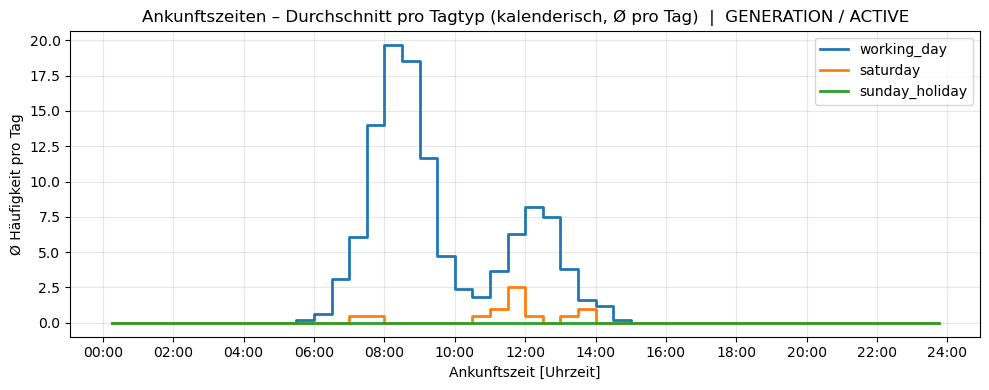

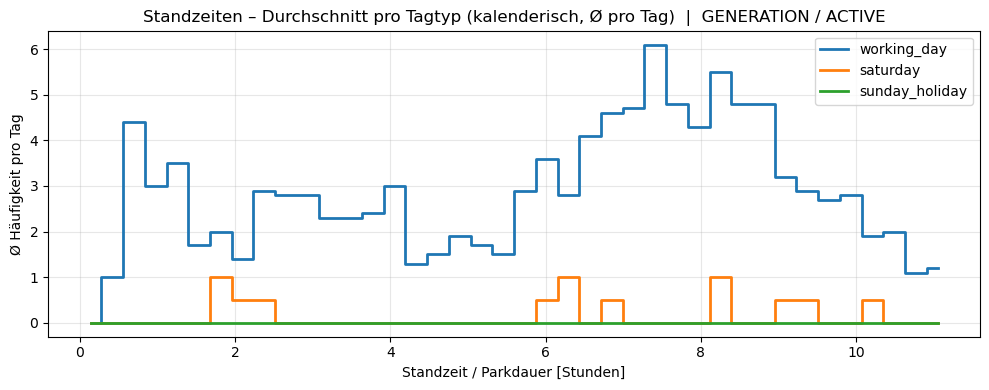

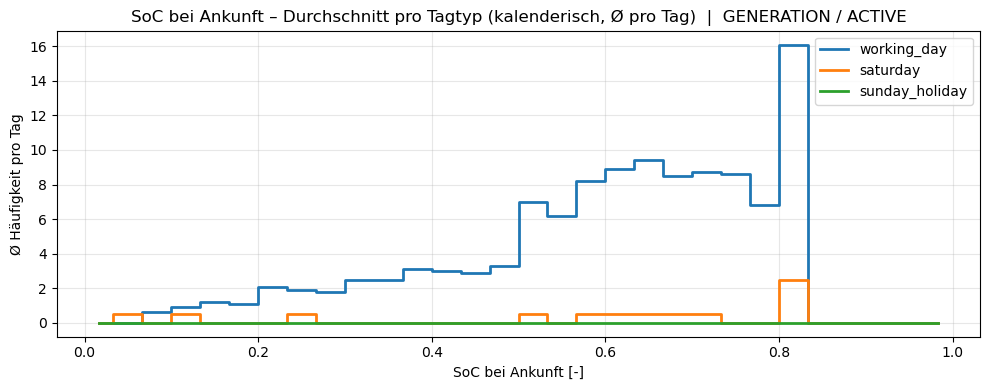

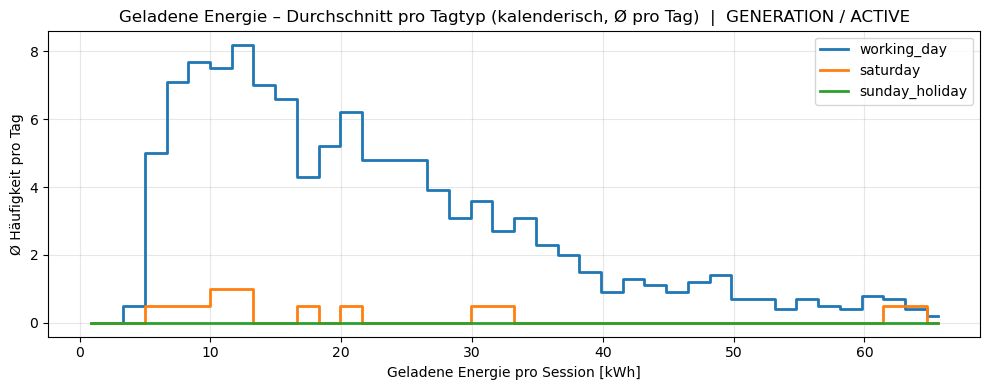

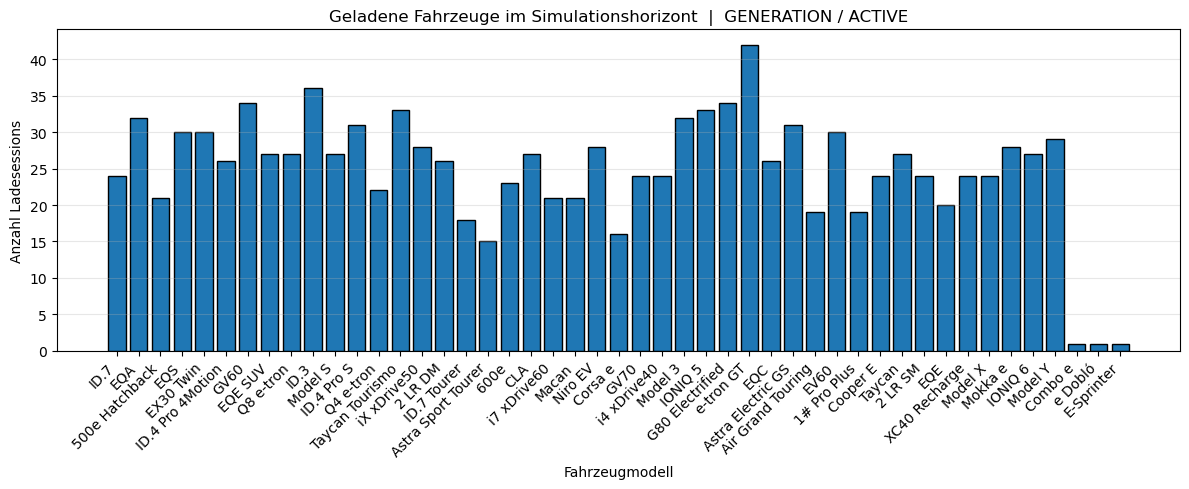

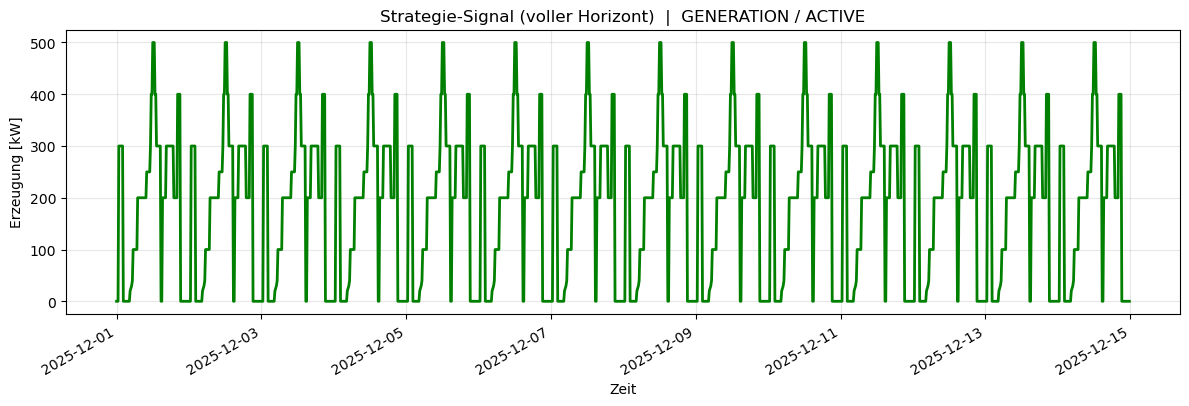

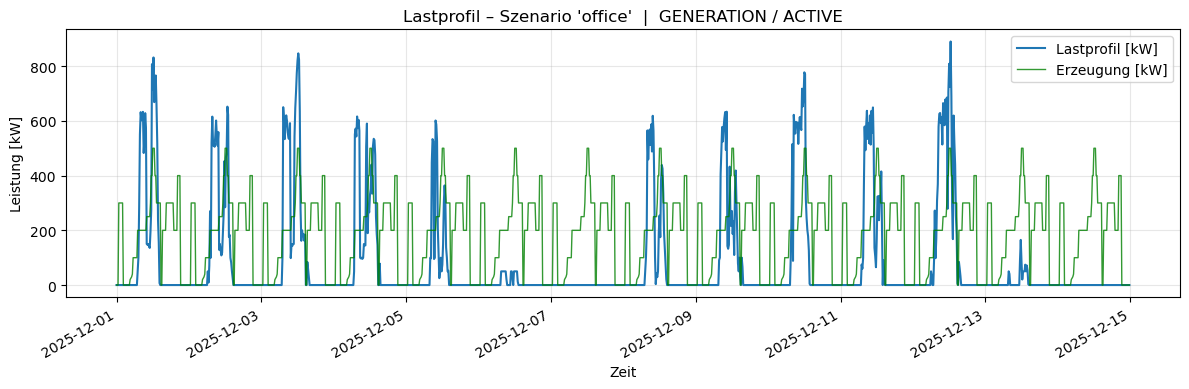

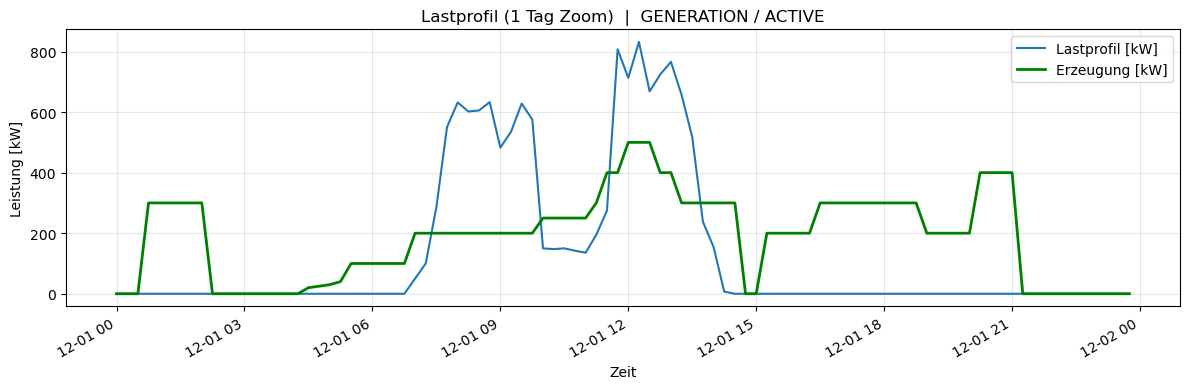

In [3]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from collections import Counter, defaultdict
from datetime import datetime, timedelta, date

warnings.simplefilter("always", UserWarning)
from IPython.display import display, HTML


# =============================================================================
# 0) Notebook-UI Helpers
# =============================================================================

def show_strategy_status_html(charging_strategy: str, strategy_status: str) -> None:
    status = (strategy_status or "IMMEDIATE").upper()
    strat = (charging_strategy or "immediate").upper()

    color_map = {
        "ACTIVE": "#1a7f37",
        "INACTIVE": "#c62828",
        "IMMEDIATE": "#616161",
    }
    emoji_map = {
        "ACTIVE": "🟢",
        "INACTIVE": "🔴",
        "IMMEDIATE": "⚪",
    }

    color = color_map.get(status, "#616161")
    emoji = emoji_map.get(status, "⚪")

    html = f"""
    <div style="
        font-size:18px; font-weight:800; color:{color};
        padding:10px 12px; border:2px solid {color};
        border-radius:12px; display:flex; align-items:center;
        gap:10px; width:fit-content; margin:8px 0 14px 0;
        background: rgba(0,0,0,0.02);
    ">
      <span style="font-size:22px">{emoji}</span>
      <div>
        <div>Charging strategy: <span style="letter-spacing:0.5px">{strat}</span></div>
        <div>Strategy status: <span style="letter-spacing:0.5px">{status}</span></div>
      </div>
    </div>
    """
    display(HTML(html))


def decorate_title_with_status(base_title: str, charging_strategy: str, strategy_status: str) -> str:
    status = (strategy_status or "IMMEDIATE").upper()
    strat = (charging_strategy or "immediate").upper()
    return f"{base_title}  |  {strat} / {status}"


# =============================================================================
# 1) Projektpfad setzen, damit "model" importierbar ist
# =============================================================================

project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.append(project_root)

from model.simulation import (
    load_scenario,
    simulate_load_profile,
    build_strategy_signal_series,   # ✅ aus simulation.py
)


# =============================================================================
# 2) Szenario laden und Simulation durchführen
# =============================================================================

scenario_name = "office"
scenario_path = f"../scenarios/{scenario_name}.yaml"
scenario = load_scenario(scenario_path)

try:
    timestamps, load_kw, sessions, charging_counts, holiday_dates, charging_strategy, strategy_status, debug_rows = (
        simulate_load_profile(scenario, record_debug=True)
    )
except ValueError as e:
    print("\n❌ Simulation abgebrochen:\n")
    print(str(e))
    timestamps = load_kw = sessions = charging_counts = holiday_dates = None
    charging_strategy = strategy_status = None
    debug_rows = None

if charging_strategy is not None and strategy_status is not None:
    show_strategy_status_html(charging_strategy, strategy_status)
    print(f"Charging strategy: {charging_strategy.upper()}")
    print(f"Strategy status:   {strategy_status}")


# =============================================================================
# 2b) Strategie-Signalreihe (aligned) + Labels
# =============================================================================

strategy_series = None
strategy_ylabel = None

if timestamps is not None and charging_strategy is not None:
    if charging_strategy.lower() in ("market", "generation"):
        # normalize_to_internal=True:
        #   market -> €/kWh, generation -> kW
        strategy_series, strategy_ylabel = build_strategy_signal_series(
            scenario=scenario,
            timestamps=timestamps,
            charging_strategy=charging_strategy,
            normalize_to_internal=True,
            strategy_resolution_min=15,
        )


# =============================================================================
# 2c) DEBUG: Details der Fahrzeuge ausgeben, die über Erzeugung hinaus Netzbezug verursachen
# =============================================================================
# Diese Auswertung nutzt debug_rows aus simulate_load_profile(record_debug=True).
# Sie zeigt Zeitschritte mit Netzbezug und listet die beteiligten Sessions inkl.
# Ankunft, Abfahrt, Standzeit, Slack und Notfall-Flag.
#
# Hinweis:
# - grid_import_kw > 0 bedeutet: Standort hat mehr Ladeleistung gezogen, als aus PV-Überschuss verfügbar war.
# - Das kann passieren, wenn mindestens eine Session zeitkritisch ist (Notfall) oder Limits (Charger/Fahrzeug)
#   das "Vorziehen" in Zeiten mit hoher PV verhindern.

df_debug = None
df_grid = None
top_steps = None

if debug_rows is not None and len(debug_rows) > 0:
    df_debug = pd.DataFrame(debug_rows).copy()

    # Nur Zeitschritte/Einträge mit Netzbezug > 0
    if "grid_import_kw" in df_debug.columns:
        df_grid = df_debug[df_debug["grid_import_kw"] > 1e-6].copy()
    else:
        df_grid = pd.DataFrame()

    print("\nDEBUG – Netzbezug-Auswertung")
    print("Anzahl Debug-Zeilen insgesamt:", len(df_debug))
    print("Anzahl Debug-Zeilen mit Netzbezug:", len(df_grid))
    if len(df_grid) > 0:
        print("Anzahl Zeitschritte mit Netzbezug:", df_grid["ts"].nunique())

        # Top-Zeitschritte mit höchstem Netzbezug (max pro Zeitschritt)
        top_steps = (
            df_grid.groupby("ts")["grid_import_kw"]
            .max()
            .sort_values(ascending=False)
            .head(10)
        )

        display(top_steps)

        # Details pro Top-Zeitschritt anzeigen
        for ts in top_steps.index:
            block = df_grid[df_grid["ts"] == ts].copy()

            cols = [
                "ts",
                "vehicle_name",
                "arrival_time",
                "departure_time",
                "parking_hours",
                "slack_minutes",
                "is_emergency",
                "pv_kw",
                "base_kw",
                "pv_surplus_kw",
                "site_total_power_kw",
                "grid_import_kw",
                "has_any_emergency_this_step",
            ]
            cols = [c for c in cols if c in block.columns]

            # Sortierung: Notfälle zuerst, dann kleinster Slack
            if "is_emergency" in block.columns and "slack_minutes" in block.columns:
                block = block.sort_values(["is_emergency", "slack_minutes"], ascending=[False, True])

            print(f"\n=== Netzbezug-Zeitschritt: {ts} ===")
            display(block[cols])

    else:
        print("Kein Netzbezug erkannt (grid_import_kw == 0 über den gesamten Horizont).")
else:
    print("\nDEBUG – keine debug_rows vorhanden (record_debug=True aktivieren oder Simulation abgebrochen).")


# =============================================================================
# 3) Kontrollen
# =============================================================================

if timestamps is not None:
    print("Verwendetes Szenario:", scenario_name)
    print("Vorhandene Ladepunkte am Standort:", scenario["site"]["number_chargers"])
    print(f"Erster Timestamp: {timestamps[0]}")
    print(f"Letzter Timestamp: {timestamps[-1]}")
    print(f"Simulationshorizont: {scenario['simulation_horizon_days']} Tage")


# =============================================================================
# 4) Day-Type-Logik lokal im Notebook
# =============================================================================

def determine_day_type_notebook(dt, holiday_dates):
    d = dt.date()
    if d in holiday_dates:
        return "sunday_holiday"
    wd = dt.weekday()  # Mo=0 ... So=6
    if wd == 6:
        return "sunday_holiday"
    if wd == 5:
        return "saturday"
    return "working_day"


# =============================================================================
# 5) Feature-Helper pro Session
# =============================================================================

def minutes_since_midnight(dt):
    return dt.hour * 60 + dt.minute + dt.second / 60.0

def feat_arrival_hours(s):
    return minutes_since_midnight(s["arrival_time"]) / 60.0

def feat_parking_hours(s):
    return (s["departure_time"] - s["arrival_time"]).total_seconds() / 3600.0

def feat_soc_arrival(s):
    return float(s["soc_arrival"])

def feat_delivered_kwh(s):
    return float(s.get("delivered_energy_kwh", 0.0))


# =============================================================================
# 6) Tage kalendarisch zählen
# =============================================================================

if timestamps is not None:
    start_dt = datetime.fromisoformat(scenario["start_datetime"])
    horizon_days = int(scenario["simulation_horizon_days"])
    all_days = [start_dt.date() + timedelta(days=i) for i in range(horizon_days)]

    days_by_type_calendar = defaultdict(list)
    for d in all_days:
        dt_midday = datetime(d.year, d.month, d.day, 12, 0)
        day_type = determine_day_type_notebook(dt_midday, holiday_dates)
        days_by_type_calendar[day_type].append(d)

    print("Kalenderische Tage je Tagtyp:")
    for k in ["working_day", "saturday", "sunday_holiday"]:
        print(f"- {k}: {len(days_by_type_calendar.get(k, []))} Tage")


# =============================================================================
# 7) Kontrollen: Sessions
# =============================================================================

if sessions is not None:
    print("\nAnzahl Ladesessions im Simulationshorizont:", len(sessions))
    print("Max. gleichzeitig ladende Fahrzeuge:", max(charging_counts) if charging_counts else 0)

    print("\nBeispiel-Sessions (erste 10):")
    for s in sessions[:10]:
        print(
            f"Fahrzeug: {s['vehicle_name']}, "
            f"Ankunft: {s['arrival_time']}, "
            f"Abfahrt: {s['departure_time']}, "
            f"Kapazität: {s['battery_capacity_kwh']} kWh, "
            f"geladene Energie: {s['delivered_energy_kwh']:.1f} kWh, "
            f"Restbedarf: {s['energy_required_kwh']:.1f} kWh"
        )


# =============================================================================
# 8) Sessions nach Datum gruppieren (für Histogramme pro Tag)
# =============================================================================

sessions_by_day = defaultdict(list)
if sessions is not None:
    for s in sessions:
        sessions_by_day[s["arrival_time"].date()].append(s)


# =============================================================================
# 9) Histogramm-Helfer
# =============================================================================

def average_hist_per_daytype_calendar(
    daytype_to_days: dict[str, list[date]],
    sessions_by_day: dict[date, list],
    value_fn,
    bin_edges: np.ndarray,
) -> dict[str, np.ndarray]:
    avg_counts_by_type: dict[str, np.ndarray] = {}
    for day_type, days in daytype_to_days.items():
        if not days:
            avg_counts_by_type[day_type] = np.zeros(len(bin_edges) - 1, dtype=float)
            continue

        daily_counts = []
        for d in days:
            sess = sessions_by_day.get(d, [])
            values = np.array([value_fn(s) for s in sess], dtype=float)
            counts, _ = np.histogram(values, bins=bin_edges)
            daily_counts.append(counts.astype(float))

        avg_counts_by_type[day_type] = np.mean(np.vstack(daily_counts), axis=0)

    return avg_counts_by_type


def plot_avg_hist_overlay(avg_counts_by_type, bin_edges, xlabel, base_title, charging_strategy, strategy_status,
                          xticks=None, xtick_labels=None):
    plt.figure(figsize=(10, 4))
    centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0

    for dt_type in ["working_day", "saturday", "sunday_holiday"]:
        if dt_type not in avg_counts_by_type:
            continue
        plt.step(centers, avg_counts_by_type[dt_type], where="mid", linewidth=2, label=dt_type)

    plt.xlabel(xlabel)
    plt.ylabel("Ø Häufigkeit pro Tag")
    plt.title(decorate_title_with_status(base_title, charging_strategy, strategy_status))
    plt.grid(True, alpha=0.3)
    plt.legend()

    if xticks is not None:
        plt.xticks(xticks, xtick_labels if xtick_labels is not None else None)

    plt.tight_layout()
    plt.show()


# =============================================================================
# 10) Ankunftszeiten
# =============================================================================

if timestamps is not None and sessions is not None:
    arrival_bin_edges = np.linspace(0, 24, 49)

    avg_arrival = average_hist_per_daytype_calendar(
        daytype_to_days=days_by_type_calendar,
        sessions_by_day=sessions_by_day,
        value_fn=feat_arrival_hours,
        bin_edges=arrival_bin_edges,
    )

    plot_avg_hist_overlay(
        avg_counts_by_type=avg_arrival,
        bin_edges=arrival_bin_edges,
        xlabel="Ankunftszeit [Uhrzeit]",
        base_title="Ankunftszeiten – Durchschnitt pro Tagtyp (kalenderisch, Ø pro Tag)",
        charging_strategy=charging_strategy,
        strategy_status=strategy_status,
        xticks=list(range(0, 25, 2)),
        xtick_labels=[f"{h:02d}:00" for h in range(0, 25, 2)],
    )


# =============================================================================
# 11) Standzeiten
# =============================================================================

if timestamps is not None and sessions is not None:
    all_parking = np.array([feat_parking_hours(s) for s in sessions], dtype=float)
    max_p = np.percentile(all_parking, 99) if len(all_parking) else 1.0
    max_p = max(max_p, 0.5)
    parking_bin_edges = np.linspace(0, max_p, 41)

    avg_parking = average_hist_per_daytype_calendar(
        daytype_to_days=days_by_type_calendar,
        sessions_by_day=sessions_by_day,
        value_fn=feat_parking_hours,
        bin_edges=parking_bin_edges,
    )

    plot_avg_hist_overlay(
        avg_counts_by_type=avg_parking,
        bin_edges=parking_bin_edges,
        xlabel="Standzeit / Parkdauer [Stunden]",
        base_title="Standzeiten – Durchschnitt pro Tagtyp (kalenderisch, Ø pro Tag)",
        charging_strategy=charging_strategy,
        strategy_status=strategy_status,
    )


# =============================================================================
# 12) SoC bei Ankunft
# =============================================================================

if timestamps is not None and sessions is not None:
    soc_bin_edges = np.linspace(0, 1, 31)

    avg_soc = average_hist_per_daytype_calendar(
        daytype_to_days=days_by_type_calendar,
        sessions_by_day=sessions_by_day,
        value_fn=feat_soc_arrival,
        bin_edges=soc_bin_edges,
    )

    plot_avg_hist_overlay(
        avg_counts_by_type=avg_soc,
        bin_edges=soc_bin_edges,
        xlabel="SoC bei Ankunft [-]",
        base_title="SoC bei Ankunft – Durchschnitt pro Tagtyp (kalenderisch, Ø pro Tag)",
        charging_strategy=charging_strategy,
        strategy_status=strategy_status,
    )


# =============================================================================
# 13) Geladene Energie
# =============================================================================

if timestamps is not None and sessions is not None:
    all_energy = np.array([feat_delivered_kwh(s) for s in sessions], dtype=float)
    max_e = np.percentile(all_energy, 99) if len(all_energy) else 1.0
    max_e = max(max_e, 1.0)
    energy_bin_edges = np.linspace(0, max_e, 41)

    avg_energy = average_hist_per_daytype_calendar(
        daytype_to_days=days_by_type_calendar,
        sessions_by_day=sessions_by_day,
        value_fn=feat_delivered_kwh,
        bin_edges=energy_bin_edges,
    )

    plot_avg_hist_overlay(
        avg_counts_by_type=avg_energy,
        bin_edges=energy_bin_edges,
        xlabel="Geladene Energie pro Session [kWh]",
        base_title="Geladene Energie – Durchschnitt pro Tagtyp (kalenderisch, Ø pro Tag)",
        charging_strategy=charging_strategy,
        strategy_status=strategy_status,
    )


# =============================================================================
# 14) Fahrzeugzählung
# =============================================================================

if sessions is not None:
    vehicle_names = [s["vehicle_name"] for s in sessions]
    counts = Counter(vehicle_names)

    models = list(counts.keys())
    values = list(counts.values())

    plt.figure(figsize=(12, 5))
    plt.bar(models, values, edgecolor="black")
    plt.xticks(rotation=45, ha="right")
    plt.xlabel("Fahrzeugmodell")
    plt.ylabel("Anzahl Ladesessions")
    plt.title(decorate_title_with_status("Geladene Fahrzeuge im Simulationshorizont", charging_strategy, strategy_status))
    plt.grid(True, axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()


# =============================================================================
# 15) Strategy-Only Plot (wie Lastprofil: volle Zeitreihe, nicht Tagesmittel)
# =============================================================================

if timestamps is not None and strategy_series is not None and strategy_ylabel is not None:
    plt.figure(figsize=(12, 4))
    plt.plot(timestamps, strategy_series, color="green", linewidth=2)
    plt.xlabel("Zeit")
    plt.ylabel(strategy_ylabel)
    plt.title(decorate_title_with_status("Strategie-Signal (voller Horizont)", charging_strategy, strategy_status))
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.gcf().autofmt_xdate()
    plt.show()


# =============================================================================
# 16) Lastprofil + Strategie integriert
#     - MARKET: 2. y-Achse (Preis vs kW)
#     - GENERATION: 1 y-Achse (kW vs kW)
# =============================================================================

def plot_load_with_strategy(
    timestamps: list[datetime],
    load_kw: np.ndarray,
    strategy_series: np.ndarray | None,
    strategy_ylabel: str | None,
    base_title: str,
    charging_strategy: str,
    strategy_status: str,
    start_idx: int | None = None,
    end_idx: int | None = None,
    strategy_linewidth: float = 2.0,
    strategy_alpha: float = 1.0,
):
    if start_idx is None:
        start_idx = 0
    if end_idx is None:
        end_idx = len(timestamps)

    x = timestamps[start_idx:end_idx]
    y_load = load_kw[start_idx:end_idx]

    strat = (charging_strategy or "immediate").lower()

    fig, ax1 = plt.subplots(figsize=(12, 4))
    l1 = ax1.plot(x, y_load, label="Lastprofil [kW]")  # blau default
    ax1.set_xlabel("Zeit")
    ax1.set_ylabel("Leistung [kW]")
    ax1.grid(True, alpha=0.3)

    handles = []
    labels = []
    handles += l1
    labels += ["Lastprofil [kW]"]

    if strategy_series is not None and strategy_ylabel is not None:
        y_sig = strategy_series[start_idx:end_idx]

        if strat == "market":
            ax2 = ax1.twinx()
            l2 = ax2.plot(
                x, y_sig,
                color="green",
                linewidth=strategy_linewidth,
                alpha=strategy_alpha,
                label=strategy_ylabel
            )
            ax2.set_ylabel(strategy_ylabel)
            handles += l2
            labels += [strategy_ylabel]

        elif strat == "generation":
            l2 = ax1.plot(
                x, y_sig,
                color="green",
                linewidth=strategy_linewidth,
                alpha=strategy_alpha,
                label=strategy_ylabel
            )
            handles += l2
            labels += [strategy_ylabel]

    ax1.set_title(decorate_title_with_status(base_title, charging_strategy, strategy_status))
    ax1.legend(handles, labels, loc="upper right")

    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()


# =============================================================================
# 17) Lastprofil (gesamt) + Strategie
# =============================================================================

if timestamps is not None:
    plot_load_with_strategy(
        timestamps=timestamps,
        load_kw=load_kw,
        strategy_series=strategy_series,
        strategy_ylabel=strategy_ylabel,
        base_title=f"Lastprofil – Szenario '{scenario_name}'",
        charging_strategy=charging_strategy,
        strategy_status=strategy_status,
        strategy_linewidth=1.0,
        strategy_alpha=0.8,
    )


# =============================================================================
# 18) Lastprofil (1 Tag Zoom) + Strategie
# =============================================================================

if timestamps is not None:
    steps_per_day = int(24 * 60 / scenario["time_resolution_min"])
    plot_load_with_strategy(
        timestamps=timestamps,
        load_kw=load_kw,
        strategy_series=strategy_series,
        strategy_ylabel=strategy_ylabel,
        base_title="Lastprofil (1 Tag Zoom)",
        charging_strategy=charging_strategy,
        strategy_status=strategy_status,
        start_idx=0,
        end_idx=min(steps_per_day, len(timestamps)),
    )
